<h1 align='center'> Segmentação de Clientes de um Atacadista por Perfil de Compra </h1>

In [4]:
oldw <- getOption("warn")
options(warn = -1)

library(IRdisplay)

display_html(
"<script>
code_show=true; function code_toggle() { 
   if (code_show){ $('div.input').hide(); 
   } else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle); 
</script>

<br>Clique <a href='javascript:code_toggle()'>aqui</a> para mostrar o código.")

Clique aqui para mostrar o código.

In [5]:
library(dplyr)
library(data.table)
library(tidyr)
library(ggplot2)
library(stringr)
library(factoextra)
library(FactoMineR)
library(ggthemes)

<h3>Objetivo e Dados</h3>

O objetivo desta aplicação é criar segmentos de clientes de um Distribuidor Atacadista com aprendizagem não supervisionada, baseando-se no comportamento dos clientes. Desenvolvido em R.

A <a href='https://archive.ics.uci.edu/ml/datasets/wholesale+customers'>base utilizada</a> é clássica em aplicações do tipo. Em termos gerais, cada observação mostra o gasto total por categoria de produtos de cada cliente em unidades monetárias. Os segmentos são Produtos Frescos, Laticínios, Mercearia, Congelados, Higiene e Delicatesse, como mostra a tabela abaixo.

In [6]:
df <- fread("customers.csv", sep=',')
df <- subset(df, select = -c(Channel, Region))
log_df <- log(df)

head(df)
# Fitando modelo de K-Means
#fviz_nbclust(log_df, kmeans, method = "silhouette")
k2 <- kmeans(log_df, centers = 2, nstart = 25)


result <- data.frame(k2$cluster)
df$ind <- seq.int(nrow(df))
log_df$ind <- seq.int(nrow(log_df))
result$ind <- seq.int(nrow(result))

log_df <- merge(log_df, result, by='ind')
log_df <- subset(log_df, select=-c(ind))

df <- merge(df, result, by='ind')
df <- subset(df, select=-c(ind))


df_pca <- PCA(log_df[,-7], graph=F)

log_df$k2.cluster <- ifelse(log_df$k2.cluster==1,"Perfil 1", "Perfil 2")
df$k2.cluster <- ifelse(df$k2.cluster==1,"Perfil 1", "Perfil 2")

df_sum <- aggregate(.~k2.cluster, df, mean)
df_sum <- melt(df_sum, id.var=c('k2.cluster'))
df_sum$value <- round(df_sum$value/100)

Frescos,Laticinios,Mercearia,Congelados,Higiene,Delicatesse
<int>,<int>,<int>,<int>,<int>,<int>
12669,9656,7561,214,2674,1338
7057,9810,9568,1762,3293,1776
6353,8808,7684,2405,3516,7844
13265,1196,4221,6404,507,1788
22615,5410,7198,3915,1777,5185
9413,8259,5126,666,1795,1451


<h3>Resultados Gráficos</h3>

O PCA <a href='http://setosa.io/ev/principal-component-analysis/'>(Principal Component Analysis)</a> é um modo de reduzir a quantidade de dimensões de um base de dados. Nesta aplicação, o método foi utilizado apenas para visualização, monstrando no gráfico abaixo as 6 variáveis da em uma plotagem bidimensional.

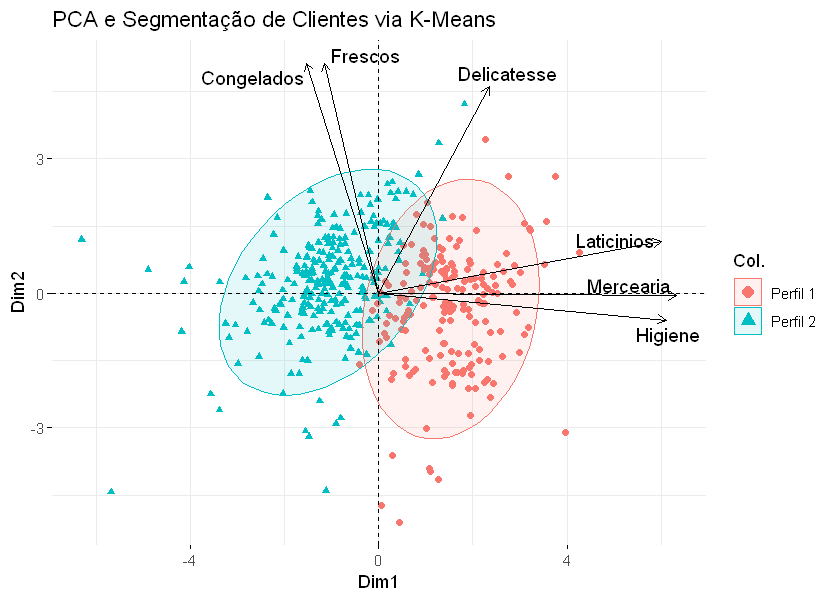

In [11]:
options(repr.plot.width=7, repr.plot.height=5)

fviz_pca_biplot(df_pca, col.ind = df$k2.cluster,
                label = "var",
                col.var = "black", repel = TRUE,
                addEllipses=TRUE, ellipse.level=0.90) +
  labs(title ="PCA e Segmentação de Clientes via K-Means" ,x="Dim1", y="Dim2")

Os perfis de compra dos clientes foram definidos pelo <a href='https://scikit-learn.org/stable/modules/neighbors.html'>modelo K Nearest Neighbors</a>, que analisa as observações mais próximas entre si (vizinhos) para criar os clusters.

Os testes feitos (suprimidos nesta apresentação) indicaram 2 perfis principais de clientes, mostrados no gráfico acima. Os clientes de perfil 2, pelo gráfico, compram mais produtos congelados e frescos, enquanto os clientes do perfil 1, nos quadrantes da direita, compram mais dos outros produtos em relação ao primeiro grupo.

Para analisar esses gastos de forma mais específica, o gráfico abaixo mostra a média de gasto por perfil de cliente e tipo de produto. Clientes do perfil 1 gastam em média muito mais com mercearia, hiegiene e Laticínios que os clientes do perfil 2, no qual o gasto está muito concentrado em produtos frescos e, em segundo lugar, congelados. 

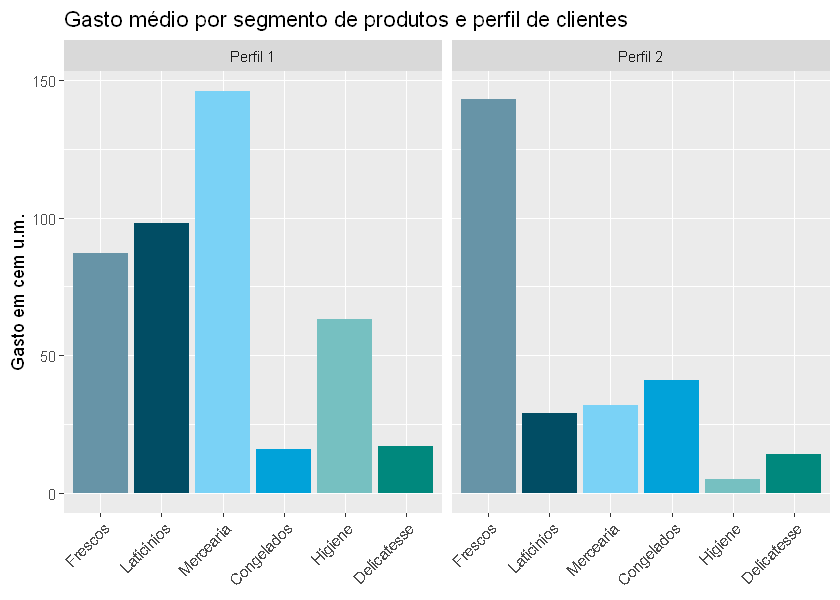

In [12]:
ggplot(data=df_sum, aes(x=variable, y=value, fill=variable)) + 
  geom_bar(stat="identity") + scale_fill_economist() +
  facet_grid(~k2.cluster) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  labs(title ="Gasto médio por segmento de produtos e perfil de clientes ", y = "Gasto em cem u.m.", x = NULL)

Mas o que significa perfil 1 e 2?

Apesar de poderosos, algoritmos de machine learning são apenas modelos estatísticos. O foco do modelo é entregar as relações entre os dados, mas ainda não tem capacidade de interpretar e analisar estes resultados.

Os perfis podem ser, por exemplo, clientes varejistas e restaurantes/bares, mas este entendimento parte de pessoas com profundo conhecimento do negócio, que vai juntar seu conhecimento com o resultado dos dados para gerar insights para o negócio.